# Automatische Hyperparameteroptimierung bei Methoden des Maschinellen Lernens
    
* Tim Köhler, Bac. Informatik


## Agenda

* Vorstellen des Problems am Beispiel künstlicher neuronaler Netze
    
* Präsentation einiger beispielhafter Lösungsansätze
    
* Vorgehen bei der Lösung des Problems
    
* Ausblick und ähnliche Projekte


## Das Problem beim finden optimaler Modelle

### Fashion-MNIST

In [4]:
# Config gedöns, damit Tensorflow auch die GPU nutzt und wir nicht ewig warten müssen um Ergebnisse zu sehen
from os import cpu_count
import tensorflow as tf
num_cores = cpu_count()
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                                     inter_op_parallelism_threads=num_cores,
                                     allow_soft_placement=True,
                                     device_count={'CPU': 1, 'GPU': 1})
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
tf.keras.backend.set_session(session)

# Vorbereiten des Datensets
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
# normalization
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

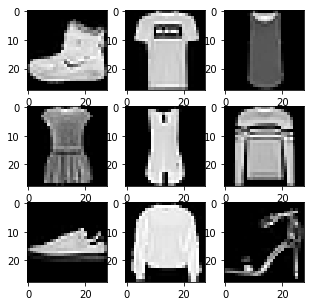

In [5]:
# Informatik soll anschaulich und verständlich sein, also sind hier ein paar unserer Ausgangsbilder
from matplotlib import pyplot as plt
%matplotlib inline
# preview the images first
plt.figure(figsize=(5, 5))
x, y = 3, 3
for i in range(9):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape(28,28), interpolation='nearest', cmap=plt.get_cmap('gray'))
plt.show()

In [6]:
# Model
def create_model(optimizer, loss, dropout):
    model = tf.keras.Sequential()

    # Must define the input shape in the first layer of the neural network
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(loss=loss,
            optimizer=optimizer,
             metrics=['accuracy'])
    return model

In [7]:
# trainiern des Models
def train_model(model):
    history = model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=50,
             validation_data=(x_test, y_test),
             verbose=0)
    return history

In [8]:
# Definieren wir uns noch schnell zwei Funktionen um das fertige model zu validieren und die Confusion Matrix darzustellen
def scorer(model, x_test, y_test):
        from sklearn.metrics import confusion_matrix
        from numpy import argmax
        scores = model.evaluate(x_test, y_test, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
        y_pred = argmax(model.predict(x_test), axis=1)
        y_val = argmax(y_test, axis=1)
        cm = confusion_matrix(y_val, y_pred)
        plot_confusion_matrix(cm, False)

def plot_confusion_matrix(cm, classes=None, normalize=False, title='conf_matrix',
                               cmap=plt.cm.get_cmap('jet')):
        from numpy import newaxis, arange
        import itertools
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, newaxis]
            print('Normalized confusion matrix')
        else:
            print('Confusion matrix, without normalization')

        if not classes:
            classes = arange(0, 10)
        fig = plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()
        
def plot_history(history):
    # Natürlich auch für unsere Augmentierten Daten
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [9]:
# Parameter
optimizer = 'rmsprop'
loss = 'categorical_crossentropy'
dropout = 0.3

model = create_model(optimizer, loss, dropout)
history = train_model(model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


KeyboardInterrupt: 

acc: 92.49%
Confusion matrix, without normalization


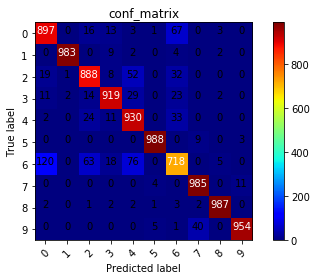

In [33]:
scorer(model, x_test, y_test)

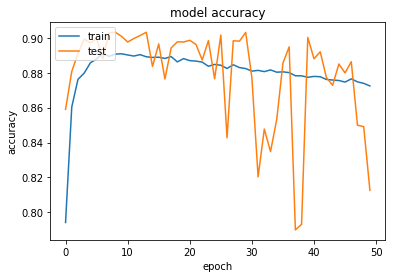

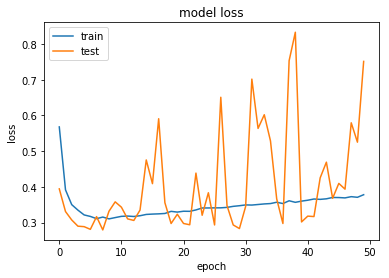

In [24]:
plot_history(history)

In [25]:
# Parameter
optimizer = 'adam'
loss = 'categorical_crossentropy'
dropout = 0.3

model = create_model(optimizer, loss, dropout)
history = train_model(model)

10000/10000 [==============================] - 0s 44us/step
[0.21915129257440566, 0.9249]
acc: 92.49%
Confusion matrix, without normalization


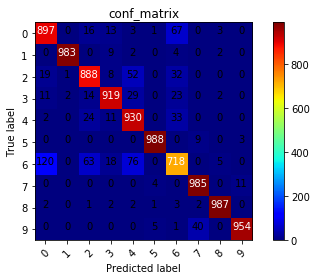

In [26]:
scorer(model, x_test, y_test)

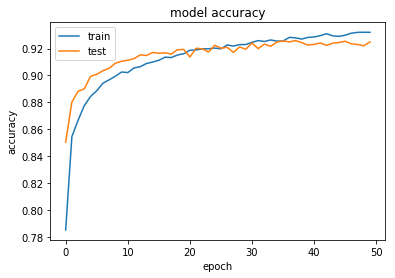

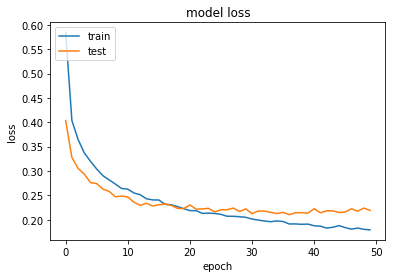

In [27]:
plot_history(history)

### Das Problem:

* Wir kennen den Funktionswert, aber nicht die Funktion
* Diese Hyperparameter lassen sich daher nicht berechnen
* Durch viel Erfahrung lassen sich ungefähre Grenzen erahnen
* Aber alles andere erfordert stupides Ausprobieren  

**=> Hoher zeitlicher Aufwand und Entwicklungskosten**

### ==>Lösung: Globale Optimierungsalgorithmen

## Beispielprobleme

### Schwefel Function

<img src="./img/schwefel.png" alt="Schwefel" style="height: 35vh; margin: auto;">
  
$$f(x)=418.9829d-\sum_{i=1}^d sin(\sqrt{|x_{i}|})$$
Mit:  
$$f(x_1, x_2, ..., x_n)=f(420.9687, 420.9687, ..., 420.9687)=0$$

* Multidimensionales Optimierungsproblem. Hier mit d = 2 dargestellt
* Sehr viele lokale Extremstellen

### Rosenbrock Function
<img src="./img/rosenbrock.jpg" alt="Rosenbrock" style="height: 35vh; margin: auto;">
  
$$f(x)=\sum_{i=1}^{N-1}[100(x_{i+1}-x_i^2)^2+(1-x_i)^2]$$
Mit:  
$$f(x_1, x_2, ..., x_n) = f(1, 1, ..., 1) = 0$$

* 1960 von Howard H. Rosenbrock
* flaches, parabelförmig gekrümmtes Tal

## Mögliche Lösungsansätze

* Gird Search
* Random Search
* Gradient Based Optimization
* Bayesian Optimization
* Evolutionäre/Genetische Algorithmen
* Simulated Annealing
* Dividing Rectangles (DIRECT)
* Reinforcement Learning

### Grid Search

* Der "traditionelle" Weg
* Validiert jede mögliche Kombination der Parameter des übergebenen Suchraumes
* Sehr leicht parallelisierbar
* Aber $10$ Dimensionen mit jeweils $10$ Werten ergeben einen Suchraum mit $10^{10}$ also $10.000.000.000$ möglichen Kombinationen
* Nur für Modelle mit sehr wenigen Parametern und schneller Validierung geeignet
* Zum Beispiel SVM(Support Vector Machine)

#### Algorithmus

1. Erstellen des kartesischen Produkts der Parametermengen
1. Validierung jeder möglichen Kombination
1. Rückgabe des Sets mit dem besten Ergebnis

### Simulated Annealing

* Ein heuristisches Optimierungsverfahren
* Simuliert den Abkühlprozess von Metallen
* Atome richten sich mit abnehmender Temperatur in Kristallgittern aus
* Bis zu einem energiearmen Zustand nahe des Optimums
* Lokale Extrema werden, durch die Chance auch schlechtere Ergebnisse zu übernehmen, wieder verlassen

#### Algorithmus

1. Initialisieren von $T=100$ und einem zufälligen initialen Startpunktes $P$ im Suchraum
1. Bestimmen der Energie $E$ im Punkt $P$
1. Zufällige Bestimmung eines neuen Punktes $P_i$ in der Nähe von $P$ mit einer Streuung proportional zu $\frac{1}{T}$
1. Ist die Energie des neuen Punktes $P_i$ besser als das aktuelle Optimum, übernehmen wir diesen als den neuen Startwert
1. Ist die Energie des neuen Punktes $P_i$ schlechter als das aktuelle Optimum, übernehmen wir diesen Punkt trotzdem mit einer Wahrscheinlichkeit von $\frac{1}{1+\exp(\frac{\Delta E}{T_i})}$
1. Jetzt wiederholen wir die Schritte 3 - 5, bis wir unser Ziel erreicht haben

### Evolutionäre und Genetische Algorithmen

* stochastisches, metaheuristisches Optimierungsverfahren
* Inspiriert durch die natürliche Evolution von Lebewesen
* viel einfacher, als es klingt
* liefert meist nur ein ausreichend gutes Ergebnis, selten das wirklich Beste.

### Algorithmus

<img alt="Genetische Algorithmen" src="./img/genetic.png" style="margin: auto; height: 50vh;">

1. Initialisierung einer zufälligen Population. Eine Population besteht aus mehreren Individuen, die durch ihre "Gene" jeweils eine mögliche Lösung repräsentieren.
1. Berechnen aller Funktionswerte (Fitness) der aktuellen Population.
1. Auswahl geeigneter Individuen aus der aktuellen Population, die als "Eltern" für die nächste Population dienen.
1. Rekombination jeweils zweier "Eltern", um daraus neue "Kinder" für die folgende Population zu erstellen
1. Es besteht eine sehr geringe Chance, dass bei jedem neu erstellten "Kind" eine zufällige Mutation in den Genen stattfindet, um auch den Bereich außerhalb der "Eltern" zu berücksichtigen.
1. Dann wird nur noch die neue Generation zusammengefügt
1. Und die Punkte 2 - 6 wiederholt

## Vorgehen
### Suchraum
### Zielfunktion
### Grid Search

## Ausblick